In [17]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# REPRODUCIBILITY
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
# CONFIG
TRAIN_PATH = "LSTM-Multivariate_pollution.csv"
TEST_PATH = "pollution_test_data1.csv"

TIME_STEPS = 12
BATCH_SIZE = 128
EPOCHS     = 50
PATIENCE   = 10
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# LOAD & ALIGN COLUMNS
df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [5]:
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [6]:
# DROP date, redudant code in this case but for safety reasons out of habit in bigger pipelines
if "date" in df_train.columns:
          df_train = df_train.drop(columns=["date"])
          
cols = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]
df_train = df_train[cols]
df_test = df_test[cols]
df_train

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [7]:
df_test

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,128,-16,4,1027,SE,3.58,0,0
1,77,-17,5,1027,SE,7.60,0,0
2,65,-16,4,1027,SE,9.39,0,0
3,79,-16,1,1028,cv,0.89,0,0
4,93,-14,0,1028,NE,1.79,0,0
...,...,...,...,...,...,...,...,...
341,8,-23,-2,1034,NW,231.97,0,0
342,10,-22,-3,1034,NW,237.78,0,0
343,10,-22,-3,1034,NW,242.70,0,0
344,8,-22,-4,1034,NW,246.72,0,0


In [8]:
# SIMPLE MISSING VALUE HANDLING
num_cols = ["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain"]
df_train[num_cols] = df_train[num_cols].interpolate(limit_direction="both", axis=0)
df_test[num_cols]  = df_test[num_cols].interpolate(limit_direction="both", axis=0)

df_train["wnd_dir"] = df_train["wnd_dir"].ffill().bfill()
df_test["wnd_dir"] = df_test["wnd_dir"].ffill().bfill()

In [9]:
# LEAK_FREE PREPROCESSING PIPELINE
numeric_features = num_cols
cat_features = ["wnd_dir"]

preprocessor = ColumnTransformer(
          transformers=[
                    ("num", MinMaxScaler(), numeric_features),
                    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
          ], remainder="drop"
)
preprocessor.fit(df_train)

X_train_full = preprocessor.transform(df_train).astype(np.float32)
X_test_full = preprocessor.transform(df_test).astype(np.float32)

print("Processed feature dims (train/test):", X_train_full.shape, X_test_full.shape)

Processed feature dims (train/test): (43800, 11) (346, 11)


In [10]:
# CREATE SEQUENCES
def create_sequences(X, time_steps):
          xs, ys = [], []
          for i in range(len(X) - time_steps):
                    xs.append(X[i:i+time_steps])
                    ys.append(X[i+time_steps, 0]) # pollution is column index 0
          return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

Xtr_seq, ytr_seq = create_sequences(X_train_full, TIME_STEPS)
Xte_seq, yte_seq = create_sequences(X_test_full, TIME_STEPS)

print("Xtr_seq shape:", Xtr_seq.shape, "ytr_seq shape:", ytr_seq.shape)
print("Xte_seq shape:", Xte_seq.shape, "yte_seq shape:", yte_seq.shape)

Xtr_seq shape: (43788, 12, 11) ytr_seq shape: (43788,)
Xte_seq shape: (334, 12, 11) yte_seq shape: (334,)


In [11]:
# DATA LOADERS
train_dataset = TensorDataset(torch.from_numpy(Xtr_seq), torch.from_numpy(ytr_seq))
train_dataset

In [12]:
val_split = 0.1
val_size = int(len(Xtr_seq) * val_split)
if val_size > 0:
          X_val = Xtr_seq[-val_size:]
          y_val = ytr_seq[-val_size:]
          X_tr = Xtr_seq[:-val_size]
          y_tr = ytr_seq[:-val_size]
          train_loader = DataLoader(
                    TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
                    batch_size=BATCH_SIZE, shuffle=True
          )
          val_loader = DataLoader(
                    TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
                    batch_size=BATCH_SIZE, shuffle=False
          )
else:
          train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
          val_loader = None

In [13]:
# MODEL
class ConvLSTMModel(nn.Module):
          def __init__(self, n_features):
                    super().__init__()
                    self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=2)
                    self.relu = nn.ReLU()
                    self.bn1 = nn.BatchNorm1d(64)
                    self.dropout1 = nn.Dropout(0.2)
                    self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
                    self.bn2 = nn.BatchNorm1d(64)
                    self.dropout2 = nn.Dropout(0.2)
                    self.fc1 = nn.Linear(64, 32)
                    self.fc2 = nn.Linear(32, 1)
                    
          def forward(self, x):
                    # x: [batch, time_steps, features]
                    x = x.permute(0,2,1) # Conv1d expects [batch, channels, seq_len]
                    x = self.conv1(x)
                    x = x[:, :, :-2] # remove padding to keep causal effect
                    x = self.relu(x)
                    x = self.bn1(x)
                    x = self.dropout1(x)
                    x = x.permute(0,2,1) # back to [batch, seq_len, features] for LSTM
                    x,_ = self.lstm(x)
                    x = x[:,-1,:] # take last timestep output
                    x = self.bn2(x)
                    x = self.dropout2(x)
                    x = self.fc1(x)
                    x = self.relu(x)
                    x = self.fc2(x)
                    return x.squeeze()

n_features = Xtr_seq.shape[2]
model = ConvLSTMModel(n_features).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss() # Huber loss                   

In [14]:
# TRAINING LOOP
best_val_loss = np.inf
patience_counter = 0
train_losses, val_losses = [], []
best_model_state = None # in-memory storage of best weights

for epoch in range(EPOCHS):
          model.train()
          epoch_losses = []
          for xb, yb in train_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    optimizer.zero_grad()
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    loss.backward()
                    optimizer.step()
                    epoch_losses.append(loss.item())
          train_loss = np.mean(epoch_losses)
          train_losses.append(train_loss)
          
          if val_loader is not None:
                    model.eval()
                    val_epoch_losses = []
                    with torch.no_grad():
                              for xb, yb in val_loader:
                                        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                                        pred = model(xb)
                                        loss = criterion(pred, yb)
                                        val_epoch_losses.append(loss.item())
                    val_loss = np.mean(val_epoch_losses)
                    val_losses.append(val_loss)
                    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val loss={val_loss:.4f}")
                    
                    # in-memory best weights tracking
                    if val_loss < best_val_loss:
                              best_val_loss = val_loss
                              best_model_state = model.state_dict()
                              patience_counter = 0
                    else:
                              patience_counter += 1
                              if patience_counter >= PATIENCE:
                                        print("Early stopping!")
                                        break
          else:
                    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}")
                    
# Restore best weights in-memory
if best_model_state is not None:
          model.load_state_dict(best_model_state)

Epoch 1: Train Loss=0.0031, Val loss=0.0007
Epoch 2: Train Loss=0.0011, Val loss=0.0005
Epoch 3: Train Loss=0.0008, Val loss=0.0004
Epoch 4: Train Loss=0.0007, Val loss=0.0004
Epoch 5: Train Loss=0.0006, Val loss=0.0003
Epoch 6: Train Loss=0.0006, Val loss=0.0003
Epoch 7: Train Loss=0.0006, Val loss=0.0003
Epoch 8: Train Loss=0.0005, Val loss=0.0003
Epoch 9: Train Loss=0.0005, Val loss=0.0003
Epoch 10: Train Loss=0.0005, Val loss=0.0003
Epoch 11: Train Loss=0.0005, Val loss=0.0003
Epoch 12: Train Loss=0.0005, Val loss=0.0003
Epoch 13: Train Loss=0.0005, Val loss=0.0003
Epoch 14: Train Loss=0.0005, Val loss=0.0003
Epoch 15: Train Loss=0.0005, Val loss=0.0003
Epoch 16: Train Loss=0.0005, Val loss=0.0003
Epoch 17: Train Loss=0.0005, Val loss=0.0003
Epoch 18: Train Loss=0.0005, Val loss=0.0003
Epoch 19: Train Loss=0.0004, Val loss=0.0003
Epoch 20: Train Loss=0.0004, Val loss=0.0003
Epoch 21: Train Loss=0.0004, Val loss=0.0003
Epoch 22: Train Loss=0.0004, Val loss=0.0002
Epoch 23: Train Los

In [15]:
# PREDICTION
model.eval()
with torch.no_grad():
          Xte_tensor = torch.from_numpy(Xte_seq).to(DEVICE)
          y_pred_scaled = model(Xte_tensor).cpu().numpy()
y_true_scaled = yte_seq

# INVERSE SCALE
num_scaler = preprocessor.named_transformers_["num"]
pollution_min = num_scaler.data_min_[0]
pollution_max = num_scaler.data_max_[0]
pollution_range = pollution_max - pollution_min
y_pred = y_pred_scaled * pollution_range + pollution_min
y_true = y_true_scaled * pollution_range + pollution_min

# METRICS
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\nEVALUATION on TEST SEQUENCES")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")



EVALUATION on TEST SEQUENCES
MAE:  19.1674
MSE:  870.8742
RMSE: 29.5106
R2:   0.9108


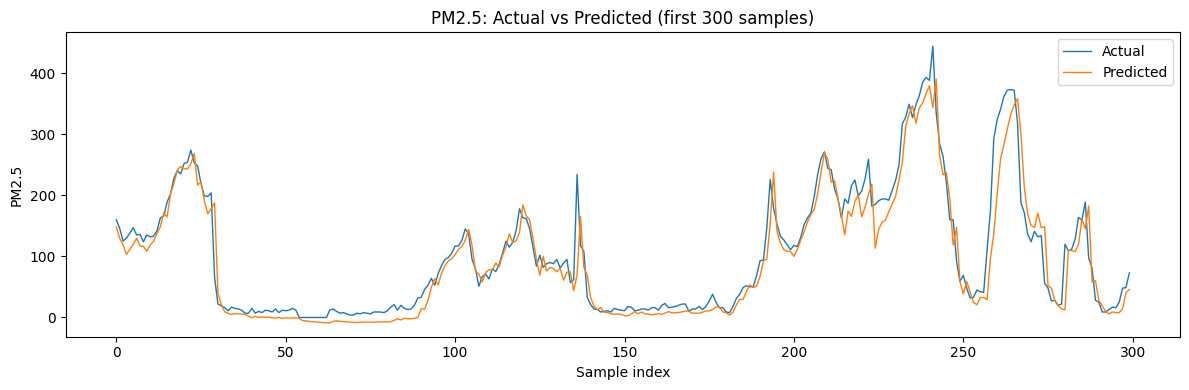

In [18]:
# PLOTS
N = min(300, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="Actual", linewidth=1)
plt.plot(y_pred[:N], label="Predicted", linewidth=1)
plt.title(f"PM2.5: Actual vs Predicted (first {N} samples)")
plt.xlabel("Sample index")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

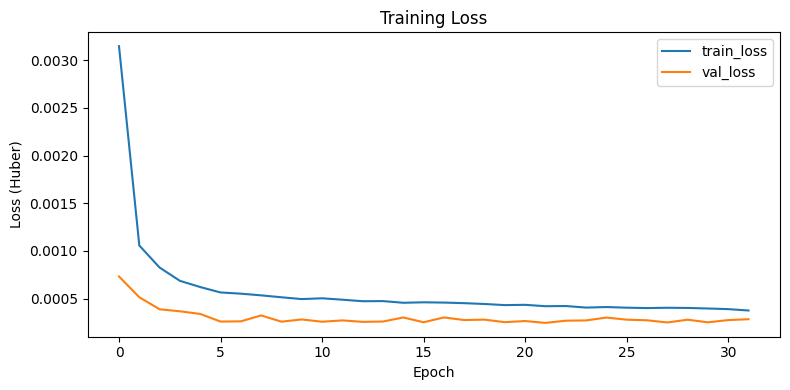

In [19]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="train_loss")
if val_loader is not None:
    plt.plot(val_losses, label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber)")
plt.legend()
plt.tight_layout()
plt.show()